## Text Processing Lab

In [1]:
%load_ext watermark
%watermark -v -p numpy,mlxtend,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
mlxtend  : 0.23.1
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm


def process_text(text: list[str]) -> list[str]:
    """
    Process a list of text lines to extract product IDs and categories.

    Parameters
    ----------
    text : list[str]
        A list of strings representing lines of text to process.

    Returns
    -------
    list[str]
        A list of strings, each containing a product ID and its associated category.
    """
    result: list[str] = []
    # Starts with a capital letter and then lowercase letters
    pattern: re.Pattern[str] = re.compile(r"^[A-Z][a-z]+")
    prod_id: str = ""

    for line in tqdm(text, desc="Processing Text", unit="line", ncols=100):
        line: str = line.strip()
        if len(line.split(",")) == 1 and not pattern.match(line):
            prod_id = line
        elif pattern.match(line):
            result.append(f"{prod_id}: {line}")

    return result

In [4]:
# fp: str = "./sample.txt"
fp: str = "../../data/categories.txt"

with open(fp, "r", encoding="latin-1") as f:
    texts: list[str] = f.readlines()

In [5]:
result: list[str] = process_text(text=texts)

Processing Text: 100%|██████████████████████████████| 7313587/7313587 [00:10<00:00, 688229.88line/s]


### Exploratory Data Analysis (EDA)

In [6]:
data: pl.DataFrame = (
    pl.DataFrame(result)
    .select(
        pl.col("column_0")
        .str.split_exact(":", 1)
        .struct.rename_fields(["product_id", "product_category"])
    )
    .unnest("column_0")
).with_columns(product_category=pl.col("product_category").str.strip())

# Drop duplicates
data = data.unique(subset=["product_id", "product_category"])
print(f"{data.shape = }")
data.head(10)

data.shape = (4869346, 2)


product_id,product_category
str,str
"""B000E3LKNE""","""Music, Rock"""
"""0521660017""","""Books, Science & Math, Biological Sciences, Biotechnology"""
"""B00004SYH4""","""Music, Dance & Electronic"""
"""1740300904""","""Books, Children's Books, Social Situations"""
"""3980407071""","""Books, Professional & Technical, Architecture, Interior Design"""
"""0787105910""","""Books, Literature & Fiction, Anthologies & Literary Collections, General"""
"""0974357901""","""Books, Biographies & Memoirs, Specific Groups"""
"""0671036203""","""Books, Self-Help, New Age"""
"""0415922003""","""Books, Humor & Entertainment, Movies, Theory"""


In [7]:
# Clean up the data
data = data.with_columns(
    product_category=pl.col("product_category").map_elements(
        lambda x: ", ".join(set(x.split(","))).strip()
    )
)

data.head(10)

product_id,product_category
str,str
"""B000E3LKNE""","""Music, Rock"""
"""0521660017""","""Biological Sciences, Books, Science & Math, Biotechnology"""
"""B00004SYH4""","""Music, Dance & Electronic"""
"""1740300904""","""Books, Children's Books, Social Situations"""
"""3980407071""","""Professional & Technical, Interior Design, Books, Architecture"""
"""0787105910""","""General, Books, Literature & Fiction, Anthologies & Literary Collections"""
"""0974357901""","""Biographies & Memoirs, Books, Specific Groups"""
"""0671036203""","""Books, Self-Help, New Age"""
"""0415922003""","""Humor & Entertainment, Books, Movies, Theory"""


In [8]:
# data_grpby: pl.DataFrame = data.group_by("product_id").agg(
#     pl.col("product_category").explode()
# )

# OR
data_grpby: pl.DataFrame = data.groupby("product_id").agg(
    pl.col("product_category").map_elements(lambda x: " ".join(x))
)

# OR
# data_grpby: pl.DataFrame = data.group_by("product_id").agg((pl.struct(pl.col("product_category"))))
data_grpby.head()

product_id,product_category
str,str
"""1859744362""","""Regional & International, Books, Vietnamese, Asian, Food & Wine, Cookbooks Books, Seafood, Cooking by Ingredient, Cookbooks, Poultry & Seafood, Food & Wine, Meat Regional & International, Books, Japanese, Asian, Food & Wine, Cookbooks"""
"""0761907637""","""Books, Psychology, Counseling, Medical Books Family Relationships, Books, Parenting & Relationships Pediatrics, Books, Medicine, Internal Medicine, Medical Books Mental Health, Books, Fitness & Dieting, Compulsive Behavior, Health Books, Medicine, Internal Medicine, Psychiatry, Medical Books, Child Books, Used & Rental Textbooks, Psychopathology, Social Sciences, Psychology, New Politics & Social Sciences, Books, Social Sciences, Children's Studies Pediatrics, Books, Medicine, Medicine & Health Sciences, Used & Rental Textbooks, Clinical, New Books, Behavioral Sciences, Science & Math Books, Psychotherapy, Used & Rental Textbooks, Social Sciences, Psychology, New"""
"""0812501403""","""Books, Fantasy, Science Fiction & Fantasy Books, Literature & Fiction"""
"""B00004S8G1""","""Movies, Movies & TV"""
"""B00005OBR9""","""Music, Classical"""


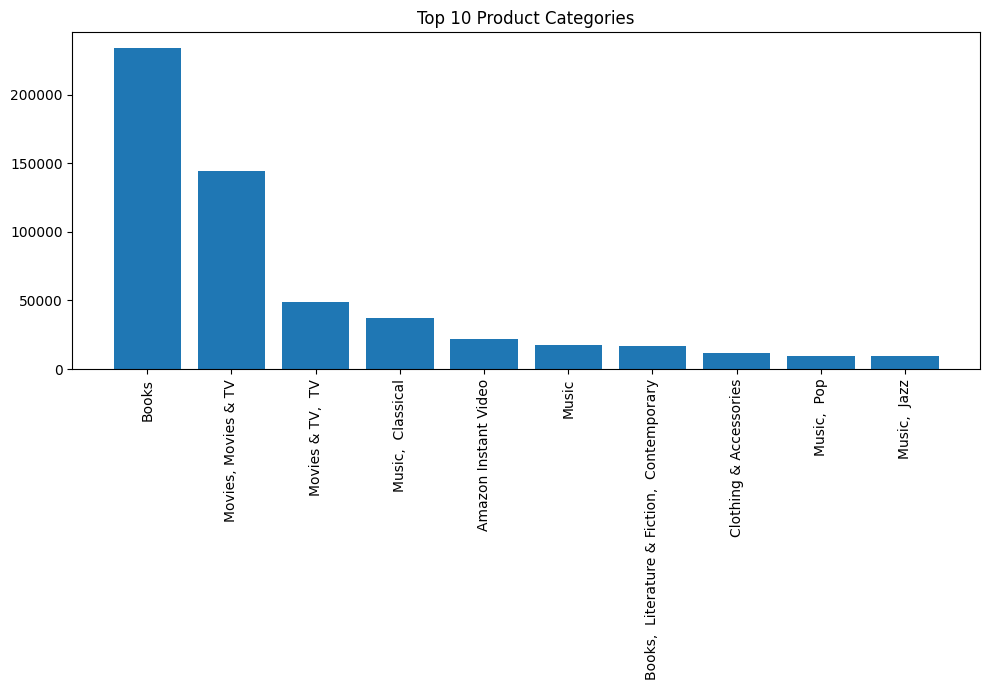

In [9]:
N: int = 10
d: pl.DataFrame = (
    data_grpby.select("product_category").to_series().value_counts(sort=True).head(N)
)
plt.figure(figsize=(10, 7))
plt.bar(d["product_category"], d["count"])
plt.xticks(rotation=90)
plt.title(f"Top {N} Product Categories")
plt.tight_layout()
plt.show()

In [10]:
data_grpby.filter(pl.col("product_id").eq("B000068VAX"))

product_id,product_category
str,str
"""B000068VAX""","""Early Learning, Children's, Software Art & Creativity, Children's, Software"""


In [11]:
import polars as pl
from typing import Generator


def parse_keys_values(filename: str) -> Generator[dict[str, str], None, None]:
    """
    Parse key-value pairs from a file.

    Parameters
    ----------
    filename : str
        The path to the file to be parsed.

    Yields
    ------
    dict[str, str]
        A dictionary containing key-value pairs parsed from the file.

    """
    entry: dict[str, str] = {}
    f = open(filename, "rb")

    # Iterate over all lines in the file.
    for l in f:
        l = l.strip()
        # The key/value pairs are separated by a colon.
        colonPos: int = l.find(b":")
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        key: str = l[:colonPos].decode("latin-1")
        value: str = l[colonPos + 2 :].decode("latin-1")
        entry[key] = value
    yield entry


def read_reviews(path: str, num: int = -1) -> pl.DataFrame:
    """
    Read reviews from a file and return them as a Polars DataFrame.

    Parameters
    ----------
    path : str
        The path to the file containing the reviews.
    num : int, optional
        The number of reviews to read. If -1, read all reviews. Default is -1.

    Returns
    -------
    pl.DataFrame
        A Polars DataFrame containing the parsed reviews.

    """
    i: int = 0
    df: dict[int, dict[str, str]] = {}
    for d in parse_keys_values(path):
        df[i] = d
        i += 1
        if i == num:
            break
    result: pl.DataFrame = pl.DataFrame([x for x in df.values()])
    return result

In [12]:
# Set verbosity level
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [13]:
fp: str = "../../data/Software.txt"
df_reviews: pl.DataFrame = read_reviews(fp).with_columns(
    pl.col("review/score").cast(pl.Float32).alias("review/score")
)
print(f"{df_reviews.shape = }")
df_reviews.head(2)

df_reviews.shape = (95085, 10)


product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
str,str,str,str,str,str,f32,str,str,str
"""B000068VBQ""","""Fisher-Price Rescue Heroes: Lava Landslide""","""8.88""","""unknown""","""unknown""","""11/11""",2.0,"""1042070400""","""Requires too much coordination""","""I bought this software for my 5 year old. He has a couple of the other RH software games and he lik…"
"""B000068VBQ""","""Fisher-Price Rescue Heroes: Lava Landslide""","""8.88""","""unknown""","""unknown""","""9/10""",2.0,"""1041552000""","""You can't pick which parts you want to play!""","""I got this for my 4 year old son because he really likes Rescue Heroes and it sounded like it would…"


In [14]:
# Join the tables
merged_data: pl.DataFrame = df_reviews.join(
    data_grpby, left_on="product/productId", right_on="product_id", how="left"
)
merged_data = merged_data.unique(subset=["product/productId", "review/userId"])
print(f"{merged_data.shape = }")
merged_data.head(10)

merged_data.shape = (84992, 11)


product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,product_category
str,str,str,str,str,str,f32,str,str,str,str
"""B000HCZ8EO""","""Microsoft Office Home and Student 2007 [Old Version]""","""145.00""","""A1EI7OQB0EBOJH""","""Robert Pyles""","""0/0""",5.0,"""1254441600""","""Microsoft Office 2007 for new laptop""","""great response from vendor. purchased item less expensive than would have been from Microsoft even …","""Business & Office, Software"""
"""B000PUNZNY""","""Fluenz Mandarin 1 + 2 Learning Suite - Macintosh""","""unknown""","""A197YF3KY62CH8""","""Esbern Johnsen""","""8/8""",5.0,"""1186790400""","""Excellent product""","""I was most pleased with both service (speedy delivery) and product (reliable playback and truely ef…","""Foreign Languages, Chinese, Language & Travel, Software Education & Reference, Software"""
"""B0000296YH""","""The Complete National Geographic 110 Years [OLD VERSION]""","""unknown""","""A3FE2GUBM8JZ3G""","""TestMagic Inc.""","""67/68""",2.0,"""963446400""","""I've had it for two years and it always irritates me!""","""The big problem with this software is this:You CANNOT copy and paste from the articles--they are st…","""Education & Reference, Software Video Games, PC, Games, Action"""
"""B00024VU58""","""eMedia Learn to Play Guitar Pack""","""129.95""","""ACQC9VTBFGC3W""","""jonathan""","""1/2""",5.0,"""1321142400""","""Great Product""","""Bought this for my son. His old guitar was broken when we moved from Germany back to the U.S. I saw…","""Home & Hobbies, Software Beginner Kits, Acoustic Guitars, Guitars, Musical Instruments"""
"""B000922CDW""","""Crystalize! (Jewel Case)""","""unknown""","""AY7QT3K5NSR1Y""","""Debra W. Herter ""debherter""""","""2/2""",4.0,"""1148083200""","""Fun Way to Pass the Time""","""I've tried the trial version of Crystalize!--Haven't bought it just yet. It's a very peaceful game …","""Education & Reference, Science, Software Video Games, PC, Games, Arcade"""
"""B0007U7L6Y""","""Topics' Instant Immersion 33 Languages (DVD). Arabic, Bengali, Brazilian (Portuguese), Chinese (Can…","""177.50""","""A18A69WOWODNY6""","""Lawrence Stone ""larry""""","""1/1""",4.0,"""1302739200""","""33 Languages""","""Good program. Had trouble using it with Vista. Ran it in compatibility mode for Windows XP, now run…","""Foreign Languages, Universal Translator, Language & Travel, Software Education & Reference, Softw…"
"""B0002LXRXY""","""ACT! 2005 [Old Version]""","""69.95""","""A19D20DCMHZ8W7""","""Gary La Court""","""14/17""",1.0,"""1093478400""","""Don't Waste Your Money""","""Everything the previous reviewer stated is accurate. The program is sluggish and slow, even on my 3…","""Business & Office, Contact Management, Software"""
"""B00002R2AC""","""Gotta Groove (Barbie Generation Girl)""","""19.95""","""A29ON7RAVEIU4P""","""Linda ""Linda""""","""1/1""",4.0,"""1041897600""","""Pretty cool fun for girls,for a little while""","""I think little girls will have fun with this game!Creating Barbie(and friends) outfits,dance moves,…","""Video Games, PC Children's, Software"""
"""B0000DIFAJ""","""""","""unknown""","""unknown""","""unknown""","""0/0""",1.0,"""1080000000""","""Missing Forms""","""I've bought Turbo tax in 2001 &amp; 2002. I didn't like the policy of Turbo Tax 2002 with a registr…","""Business & Office, Software Tax Preparation, Software Accounting & Finance, Personal Finance, Soft…"


posx and posy should be finite values
posx and posy should be finite values


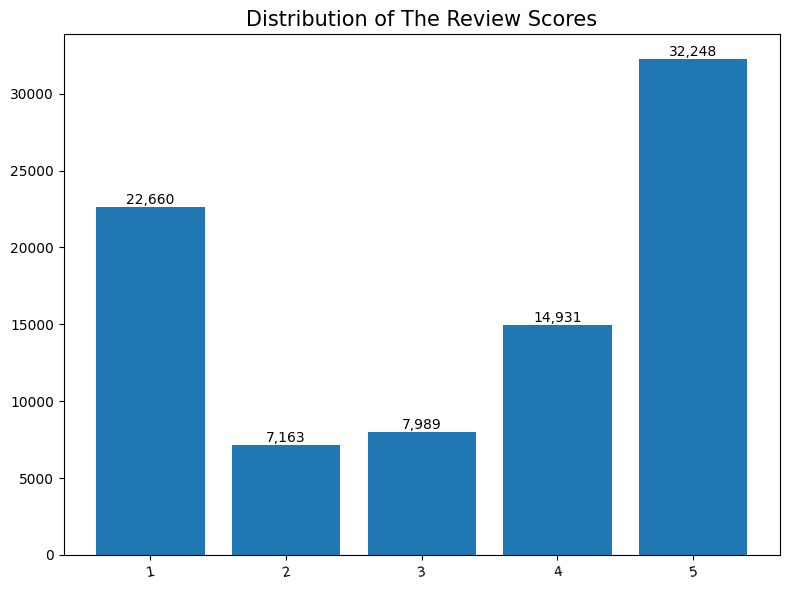

In [15]:
x_val: str = "review/score"
d: pl.DataFrame = merged_data.select(x_val).to_series().value_counts(sort=True)

plt.figure(figsize=(8, 6))
bars = plt.bar(d[x_val], d["count"])
plt.xticks(rotation=10)
plt.title(f"Distribution of The Review Scores", fontsize=15)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:,}",
        ha="center",
        va="bottom",
    )
plt.tight_layout()
plt.show()

In [16]:
x_val: str = "product/title"
d = merged_data.select(x_val).to_series().value_counts(sort=True).head(10)
# Reduce the length of the product names
d.with_columns(pl.col(x_val).str.slice(offset=0, length=20).alias(x_val))

product/title,count
str,u32
"""Microsoft Office Hom""",2143
"""Garmin City Navigato""",792
"""Apple Mac OS X Versi""",460
"""TurboTax Deluxe 2002""",357
"""Roxio Easy Media Cre""",322
"""Microsoft Windows XP""",304
"""National Geographic """,300
"""2006 TurboTax Deluxe""",292
"""Microsoft Office Pro""",288


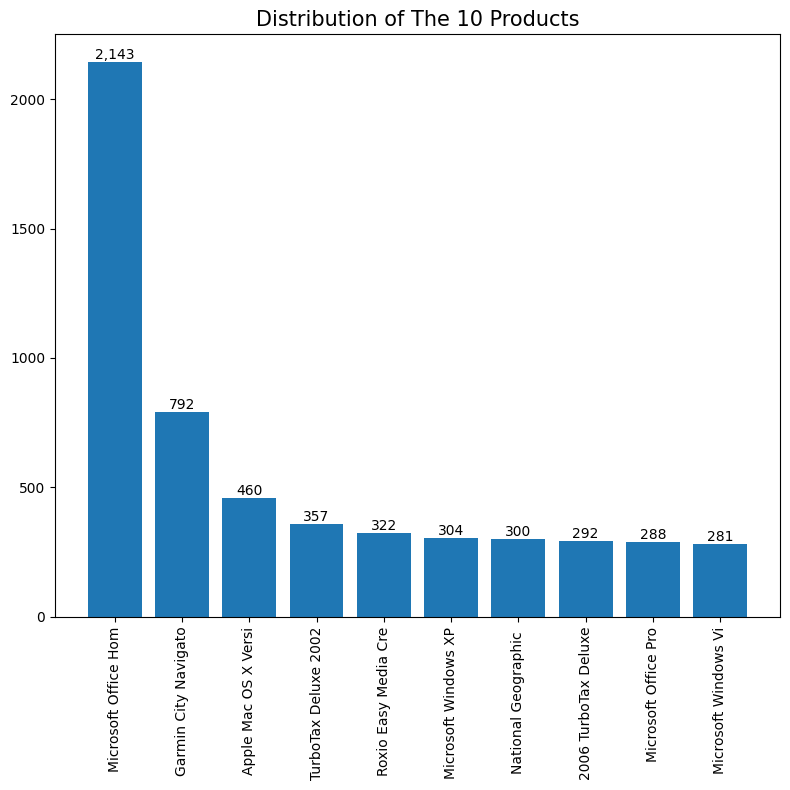

In [17]:
N: int = 10
x_val: str = "product/title"
d: pl.DataFrame = merged_data.select(x_val).to_series().value_counts(sort=True).head(N)
# Reduce the length of the product names
d = d.with_columns(pl.col(x_val).str.slice(offset=0, length=20).alias(x_val))

plt.figure(figsize=(8, 8))
bars = plt.bar(d[x_val], d["count"])
plt.xticks(rotation=90)
plt.title(f"Distribution of The {N} Products", fontsize=15)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:,}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

In [18]:
# Check the length of the reviews
merged_data = merged_data.with_columns(
    review_length=pl.col("review/text").str.len_chars()
)
merged_data = merged_data.drop_nulls()
merged_data.describe((0.25, 0.5, 0.75, 0.99))

statistic,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,product_category,review_length
str,str,str,str,str,str,str,f64,str,str,str,str,f64
"""count""","""84991""","""84991""","""84991""","""84991""","""84991""","""84991""",84991.0,"""84991""","""84991""","""84991""","""84991""",84991.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0""","""0""","""0""",0.0
"""mean""",null,null,null,null,null,null,3.317022,null,null,null,null,718.969714
"""std""",null,null,null,null,null,null,1.656402,null,null,null,null,824.959797
"""min""","""0310230691""","""""","""0.01""","""A03474796LZW0HMRLEOB""","""""","""0/0""",1.0,"""-1""","""""","""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""I install it on my notebook Dell Inspiron 8200. Instalation was …","""3-D Puzzles, Puzzles, Toys & Games Illustration & Design, Software Puzzles, Toys & Games, Brain T…",11.0
"""25%""",null,null,null,null,null,null,1.0,null,null,null,null,255.0
"""50%""",null,null,null,null,null,null,4.0,null,null,null,null,485.0
"""75%""",null,null,null,null,null,null,5.0,null,null,null,null,875.0
"""99%""",null,null,null,null,null,null,5.0,null,null,null,null,3888.0


In [19]:
# Drop outlier values
threshold: float = np.percentile(
    merged_data["review_length"].to_numpy().reshape(-1, 1), q=99.0
).round(2)
print(f"{threshold = }")
merged_data = merged_data.filter(pl.col("review_length").lt(threshold))
merged_data.describe((0.25, 0.5, 0.75, 0.99))

threshold = 3888.4


statistic,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,product_category,review_length
str,str,str,str,str,str,str,f64,str,str,str,str,f64
"""count""","""84141""","""84141""","""84141""","""84141""","""84141""","""84141""",84141.0,"""84141""","""84141""","""84141""","""84141""",84141.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0""","""0""","""0""",0.0
"""mean""",null,null,null,null,null,null,3.313985,null,null,null,null,669.928964
"""std""",null,null,null,null,null,null,1.658473,null,null,null,null,614.166979
"""min""","""0310230691""","""""","""0.01""","""A03474796LZW0HMRLEOB""","""""","""0/0""",1.0,"""-1""","""""","""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""I install it on my notebook Dell Inspiron 8200. Instalation was …","""3-D Puzzles, Puzzles, Toys & Games Illustration & Design, Software Puzzles, Toys & Games, Brain T…",11.0
"""25%""",null,null,null,null,null,null,1.0,null,null,null,null,253.0
"""50%""",null,null,null,null,null,null,4.0,null,null,null,null,480.0
"""75%""",null,null,null,null,null,null,5.0,null,null,null,null,857.0
"""99%""",null,null,null,null,null,null,5.0,null,null,null,null,3080.0


In [20]:
# Do longer reviews represent a positive or negative sentiment?
merged_data.group_by("review/score").agg(pl.col("review_length").mean()).sort(
    "review_length", descending=True
)

review/score,review_length
f32,f64
2.0,806.487784
3.0,758.374841
4.0,717.186871
1.0,676.937237
5.0,591.15565


In [21]:
merged_data.sample(5, seed=1).select(["review/helpfulness", "review/score"])

review/helpfulness,review/score
str,f32
"""0/0""",4.0
"""7/11""",3.0
"""2/2""",1.0
"""25/34""",1.0
"""0/0""",4.0


In [22]:
merged_data = merged_data.with_columns(
    pl.col("review/helpfulness")
    .map_elements(
        lambda x: int(x.split("/")[0])
        / (1 if int(x.split("/")[1]) == 0 else int(x.split("/")[1]))
    )
    .alias("review/helpfulness"),
    sentiment=pl.when(pl.col("review/score").le(3.0))
    .then(pl.lit(0))  # -ve
    .otherwise(pl.lit(1)),  # +ve
)

merged_data.describe()

statistic,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,product_category,review_length,sentiment
str,str,str,str,str,str,f64,f64,str,str,str,str,f64,f64
"""count""","""84141""","""84141""","""84141""","""84141""","""84141""",84141.0,84141.0,"""84141""","""84141""","""84141""","""84141""",84141.0,84141.0
"""null_count""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,"""0""","""0""","""0""","""0""",0.0,0.0
"""mean""",null,null,null,null,null,0.620376,3.313985,null,null,null,null,669.928964,0.554462
"""std""",null,null,null,null,null,0.408315,1.658473,null,null,null,null,614.166979,0.497028
"""min""","""0310230691""","""""","""0.01""","""A03474796LZW0HMRLEOB""","""""",0.0,1.0,"""-1""","""""","""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""I install it on my notebook Dell Inspiron 8200. Instalation was …","""3-D Puzzles, Puzzles, Toys & Games Illustration & Design, Software Puzzles, Toys & Games, Brain T…",11.0,0.0
"""25%""",null,null,null,null,null,0.071429,1.0,null,null,null,null,253.0,0.0
"""50%""",null,null,null,null,null,0.8,4.0,null,null,null,null,480.0,1.0
"""75%""",null,null,null,null,null,1.0,5.0,null,null,null,null,857.0,1.0
"""max""","""B0076ZOW3I""","""yGuide Yoga Software with Ashtanga Yoga & Great Poses I""","""unknown""","""unknown""","""~Vera""",1.0,5.0,"""999993600""","""~~~WARNING! USE THIS PRODUCT AT YOUR OWN RISK! ~~~""","""~~~The tech support was useless. I called four times without my problems being solved. All four rep…","""e-Commerce, Web Development, Programming & Web Development, Software Utilities, Internet Utiliti…",3888.0,1.0


In [23]:
merged_data["sentiment"].value_counts()

sentiment,count
i32,u32
0,37488
1,46653


## Build Classifiers

In [24]:
positive_size: int = (
    merged_data["sentiment"]
    .to_numpy()[merged_data["sentiment"].to_numpy() == 1]
    .shape[0]
)
total_size: int = merged_data["sentiment"].to_numpy().shape[0]
base_line_acc: float = (positive_size / total_size) * 100
print(f"Base line accuracy: {base_line_acc: .2f}%")

Base line accuracy:  55.45%


In [25]:
from spacy.lang.en.stop_words import STOP_WORDS


stopwords: list[str] = list(STOP_WORDS)


def tokenizer(text: str) -> list[str]:
    return text.split()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


test_size: float = 0.2
seed: int = 123

X: np.ndarray = merged_data["review/text"].to_numpy()
y: np.ndarray = merged_data["sentiment"].to_numpy()

print(f"{X.shape = } | {y.shape = }")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=test_size, random_state=seed
)
print(f"{X_train.shape = } | {X_test.shape = }")

X.shape = (84141,) | y.shape = (84141,)
X_train.shape = (67312,) | X_test.shape = (16829,)


In [27]:
from scipy.sparse import csr_matrix


max_features: int = 40_000
tfidf_vect: TfidfVectorizer = TfidfVectorizer(
    stop_words=stopwords, tokenizer=tokenizer, max_features=max_features
)
X_train_tfidf: csr_matrix = tfidf_vect.fit_transform(X_train)
X_test_tfidf: csr_matrix = tfidf_vect.transform(X_test)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from utils.ml import (
    train_model_with_cross_validation,
    plot_confusion_matrix,
    calculate_precision_recall_curves,
    plot_precision_recall_curves,
    calculate_roc_curve,
    plot_roc_curves,
)


n_components: int = 1_000
lr_pipe: Pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=stopwords, tokenizer=tokenizer, max_features=max_features
            ),
        ),
        # ("lsa", TruncatedSVD(n_components=n_components, random_state=seed)),
        (
            "lr",
            LogisticRegression(penalty="l2", C=1, max_iter=5_000, random_state=seed),
        ),
    ]
)
lr_pipe

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=40000,
                                 stop_words=['which', 'much', 'all', 'formerly',
                                             'now', 'thereupon', 'be', 'yet',
                                             'hereby', 'bottom', 'across',
                                             'our', 'less', 'ever', 'mostly',
                                             'themselves', 'and', 'of',
                                             'behind', 'the', 'can', 'here',
                                             'those', 'just', 'whoever', 'very',
                                             'nothing', 'wherein', 'not', 'has', ...],
                                 tokenizer=<function tokenizer at 0x12ae0a980>)),
                ('lr',
                 LogisticRegression(C=1, max_iter=5000, random_state=123))])

In [29]:
lr_pipe: Pipeline
lr_pipe, acc_scores, _, _ = train_model_with_cross_validation(
    X=X_train, y=y_train, estimator=lr_pipe, n_splits=5
)

Fold:  1 | Class dist.: [23992 29857] | Acc: 0.846
Fold:  2 | Class dist.: [23992 29857] | Acc: 0.854
Fold:  3 | Class dist.: [23992 29858] | Acc: 0.850
Fold:  4 | Class dist.: [23992 29858] | Acc: 0.854
Fold:  5 | Class dist.: [23992 29858] | Acc: 0.849

CV accuracy: 0.850 +/- 0.003

Time taken: 27.432 seconds


In [30]:
n_features: int = lr_pipe.named_steps["tfidf"].vocabulary_.__len__()
# n_features: int = lr_pipe.named_steps["lsa"].n_components
print(f"Number of features: {n_features:,}")

Number of features: 40,000


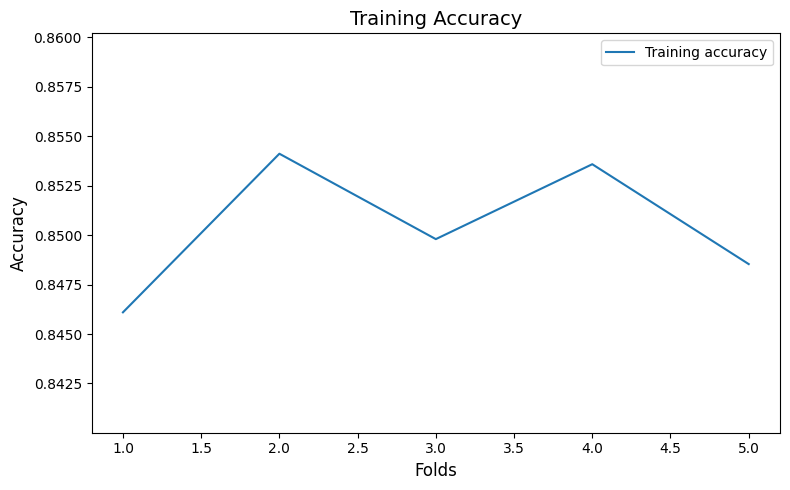

In [31]:
plt.figure(figsize=(5, 4))
min_, max_ = (
    np.min(acc_scores) - (2 * np.std(acc_scores)),
    np.max(acc_scores) + (2 * np.std(acc_scores)),
)
plt.plot(np.arange(1, len(acc_scores) + 1), acc_scores, label="Training accuracy")
plt.ylim(min_, max_)
plt.xlabel("Folds", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training Accuracy", fontsize=14)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

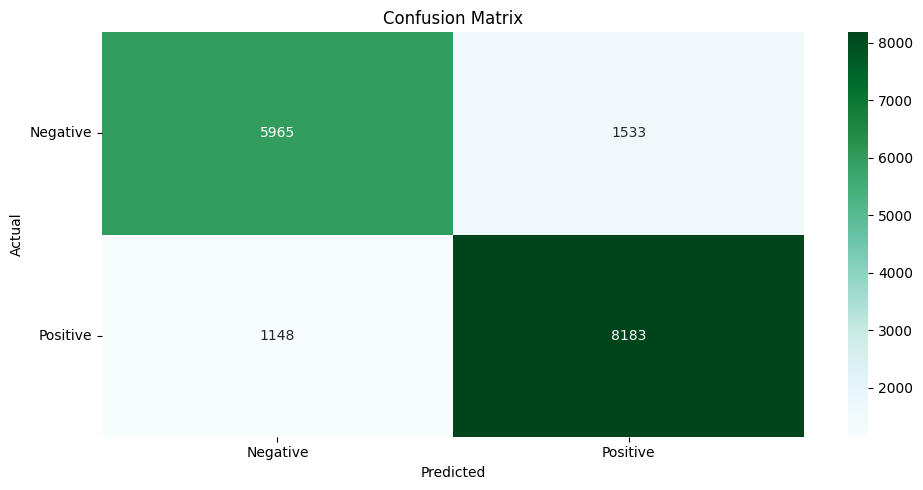

In [32]:
y_pred_train = lr_pipe.predict(X_train)
y_pred_test = lr_pipe.predict(X_test)

plot_confusion_matrix(
    y_true=y_test, y_pred=y_pred_test, labels=["Negative", "Positive"], cmap="BuGn"
)

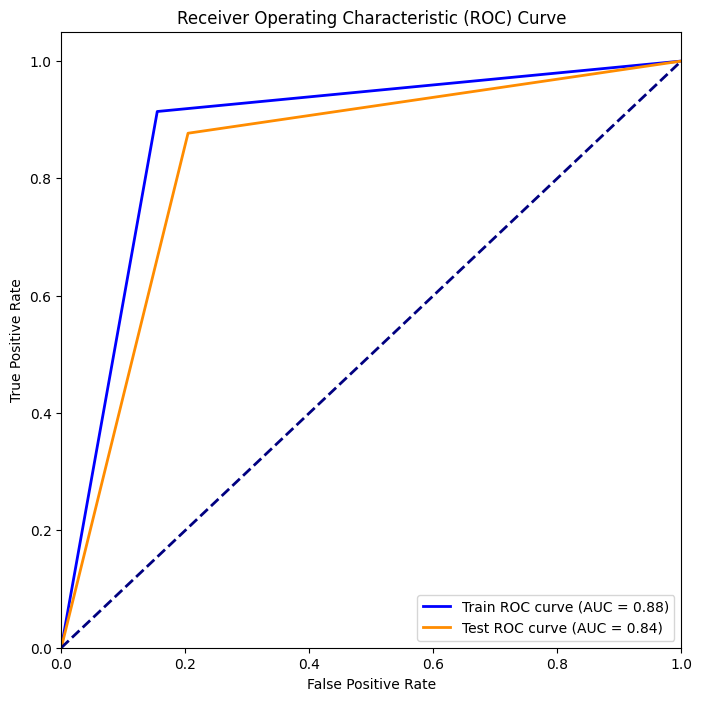

In [33]:
fpr_train, tpr_train, roc_auc_train = calculate_roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, roc_auc_test = calculate_roc_curve(y_test, y_pred_test)

plot_roc_curves(fpr_train, tpr_train, roc_auc_train, fpr_test, tpr_test, roc_auc_test)

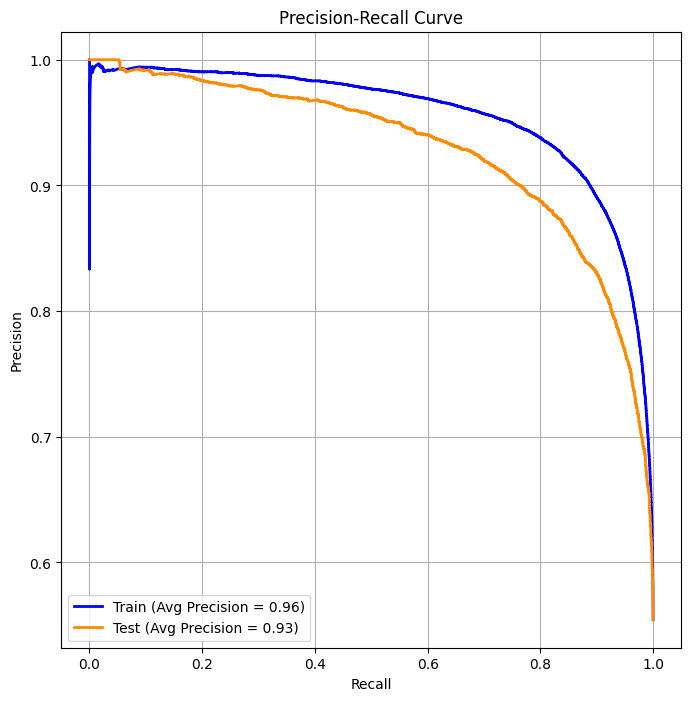

In [34]:
y_proba_train: np.ndarray = lr_pipe.predict_proba(X_train)[:, 1]
y_proba_test: np.ndarray = lr_pipe.predict_proba(X_test)[:, 1]

precision_train, recall_train, precision_test, recall_test, ap_train, ap_test = (
    calculate_precision_recall_curves(y_train, y_test, y_proba_train, y_proba_test)
)

plot_precision_recall_curves(
    recall_train, precision_train, recall_test, precision_test, ap_train, ap_test
)

In [35]:
text: str = "This product is not good. I do not recommend it."
res: list[str] = sorted(["product", "not", "good", "do", "not", "recommend"])
print(f"Actual text: \n{text}")
print(f"\nBoW input: \n{' '.join(res)!r}")
result: str = "Positive" if lr_pipe.predict([text])[0] == 1 else "Negative"
result

Actual text: 
This product is not good. I do not recommend it.

BoW input: 
'do good not not product recommend'


'Positive'

In [36]:
text: str = "This product is awful."
lr_pipe.predict_proba([text])[0]
result: str = "Positive" if lr_pipe.predict([text])[0] == 1 else "Negative"
result

'Negative'

### Neural Networks (For Classification)

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import Tensor


class ReviewsDataset(Dataset):
    """
    A dataset class for reviews and their corresponding targets.

    Parameters
    ----------
    reviews : np.ndarray
        Array of reviews. Shape: (n_samples,)
    targets : np.ndarray
        Array of targets. Shape: (n_samples,)

    Attributes
    ----------
    reviews : np.ndarray
        Array of reviews. Shape: (n_samples,)
    targets : np.ndarray
        Array of targets. Shape: (n_samples,)
    """

    def __init__(self, reviews: np.ndarray, targets: np.ndarray) -> None:
        self.reviews: Tensor = torch.tensor(reviews, dtype=torch.float32)
        self.targets: Tensor = torch.tensor(targets, dtype=torch.long)

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset.
        """
        return len(self.reviews)

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray]:
        """
        Retrieves a single sample from the dataset.
        """
        review: np.ndarray = self.reviews[index]
        target: np.ndarray = self.targets[index]
        return review, target

In [38]:
from sklearn.decomposition import TruncatedSVD


# Test the ReviewsDataset class.
n_components: int = 1_000
sample_df: pl.DataFrame = merged_data.sample(100, shuffle=True)
tfidf_vectorizer: TfidfVectorizer = TfidfVectorizer(
    stop_words=stopwords, tokenizer=tokenizer, max_features=max_features
)
lsa_vectorizer: TruncatedSVD = TruncatedSVD(n_components=n_components)

X_vec: csr_matrix = tfidf_vectorizer.fit_transform(
    sample_df["review/text"].to_numpy()
).toarray()
X_sample = lsa_vectorizer.fit_transform(X_vec)
y_sample: np.ndarray = sample_df["sentiment"].to_numpy()
sample_data: ReviewsDataset = ReviewsDataset(X_sample, y_sample)

console.print(sample_data[10:12])

(
    tensor([[ 1.6825e-01, -1.1543e-01, -4.8693e-02, -1.8462e-01, -7.3288e-02,
          2.7021e-01,  9.4134e-02, -1.1679e-01, -1.6053e-01, -1.3409e-01,
          2.4616e-01, -2.4017e-02, -1.0110e-01, -6.5481e-05,  3.3625e-01,
          6.4043e-02, -7.0087e-02,  1.6325e-01, -2.3083e-03, -9.1666e-03,
         -5.5978e-02,  9.2956e-02, -1.1138e-01,  1.4282e-01,  1.3027e-01,
          5.1409e-02, -1.7099e-01, -7.7416e-02,  6.3748e-02,  2.1135e-02,
          5.6678e-02, -7.9975e-02, -7.8531e-03,  1.0029e-02,  3.7598e-02,
          2.3933e-02,  2.3635e-02, -4.5364e-02,  3.1619e-02,  5.0645e-02,
         -7.5233e-02, -7.5872e-02, -4.1497e-02,  2.6763e-02,  8.7974e-02,
          4.0471e-03,  4.4703e-02, -7.8834e-02, -5.1032e-02,  1.5062e-02,
         -5.8363e-04,  2.0595e-02, -7.6212e-02, -4.7962e-02,  1.5299e-03,
         -1.2464e-01,  5.4684e-02, -1.8637e-02,  3.1710e-03, -1.3167e-01,
         -6.3275e-03,  6.7736e-02, -3.8036e-02, -7.2013e-02,  4.8722e-02,
         -6.7802e-02, -3.0088e-02,  1.9514e-03,  3.5917e-02,  3.0766e-02,
         -3.5322e-02, -3.9724e-02,  4.2232e-02,  1.7884e-02, -6.8913e-02,
         -1.1264e-01,  2.1176e-01,  1.0177e-02,  2.3891e-02,  3.9934e-02,
         -6.5324e-02, -9.5177e-03, -2.1703e-02,  6.2678e-03, -7.5103e-02,
         -1.0390e-01,  1.3253e-01,  7.4180e-02,  1.9821e-01,  5.6041e-02,
          2.4342e-01,  1.0761e-02,  1.4922e-01, -1.3534e-01,  1.2305e-01,
          1.1059e-01,  1.5061e-02, -1.3264e-02,  2.2630e-01, -3.4579e-02],
        [ 1.7328e-01, -7.9118e-02,  1.7219e-01,  1.3259e-01,  2.1266e-02,
         -7.5596e-02,  9.7570e-02,  2.5352e-02,  1.4049e-01, -1.2100e-01,
         -7.7757e-03,  6.1782e-02, -1.7032e-01,  2.1027e-01,  9.8228e-02,
          9.5904e-02,  1.1189e-01, -6.4817e-02,  9.7047e-02,  1.2390e-01,
          1.9010e-01,  1.2852e-01, -1.4818e-03, -4.2832e-02,  8.5035e-02,
          1.2099e-01, -1.4298e-01,  2.6856e-02,  2.7397e-02, -3.8524e-02,
         -3.4332e-02, -1.1196e-02,  1.7772e-02, -1.1790e-01, -1.2684e-01,
         -1.3027e-01, -6.4378e-02,  1.2988e-02, -8.3589e-02, -1.5195e-01,
          6.5790e-02, -8.5938e-03, -9.0824e-02, -1.2191e-01,  6.9582e-02,
          6.4869e-05,  4.9415e-02, -1.3180e-01, -4.6765e-02,  1.3296e-01,
          6.2998e-03, -2.7915e-03, -1.1905e-01,  3.1084e-01, -7.8229e-02,
          9.4270e-03,  7.2944e-02, -1.2493e-01, -1.0036e-01,  8.3918e-02,
          4.7478e-02, -5.7255e-02,  1.2607e-01, -9.2141e-02, -4.5767e-02,
         -1.2156e-01,  5.7474e-02, -2.0467e-01,  8.6796e-02, -1.2438e-01,
          1.8152e-02, -8.1382e-02, -7.9016e-02, -9.8718e-03,  1.4581e-01,
          1.2343e-01,  1.8710e-01, -9.2761e-02, -3.0254e-02,  1.4518e-01,
          4.4112e-02, -7.7126e-02,  3.8985e-02, -3.6187e-02, -9.8961e-02,
         -5.7939e-03,  5.3798e-02, -8.4424e-02, -8.7516e-02, -3.2636e-02,
         -6.8697e-02, -2.6754e-02, -1.1539e-01,  3.8531e-02, -5.1346e-02,
          4.1891e-02,  3.2070e-02, -8.0072e-02,  5.9775e-02, -1.1476e-01]]),
    tensor([1, 0])
)

In [53]:
test_size: float = 0.1

vect_pipe: Pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                stop_words=stopwords, tokenizer=tokenizer, max_features=max_features
            ),
        ),
        ("lsa", TruncatedSVD(n_components=n_components)),
    ]
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=test_size, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=test_size, random_state=seed
)

X_train_vec: np.ndarray = vect_pipe.fit_transform(X_train)
X_test_vec: np.ndarray = vect_pipe.transform(X_test)
X_val_vec: np.ndarray = vect_pipe.transform(X_val)

print(f"{X_train.shape = } | {X_test.shape = } | {X_val.shape = } ")

X_train.shape = (68153,) | X_test.shape = (8415,) | X_val.shape = (7573,) 


In [54]:
batch_size: int = 32

train_dataset: ReviewsDataset = ReviewsDataset(reviews=X_train_vec, targets=y_train)
test_dataset: ReviewsDataset = ReviewsDataset(reviews=X_test_vec, targets=y_test)
val_dataset: ReviewsDataset = ReviewsDataset(reviews=X_val_vec, targets=y_val)

train_dataloader: DataLoader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
test_dataloader: DataLoader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)
val_dataloader: DataLoader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)

In [67]:
from typing import TypedDict


class ModelArgs(TypedDict):
    num_features: int
    hidden_size: int
    dropout_rate: float
    num_classes: int


model_args: ModelArgs = {
    "num_features": n_components,
    "hidden_size": 2**6,
    "dropout_rate": 0.2,
    "num_classes": 2,
}
model_args

{'num_features': 1000,
 'hidden_size': 64,
 'dropout_rate': 0.2,
 'num_classes': 2}

In [68]:
model_args["num_classes"]

2

In [69]:
from torch import Tensor, nn


class ReviewsClassifier(nn.Module):
    def __init__(self, model_args: ModelArgs) -> None:
        super().__init__()

        self.dropout = nn.Dropout(model_args["dropout_rate"])
        self.out_layer = nn.Sequential(
            nn.Linear(model_args["num_features"], model_args["hidden_size"]),
            nn.Linear(model_args["hidden_size"], model_args["hidden_size"]),
            nn.Linear(model_args["hidden_size"], model_args["num_classes"]),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.dropout(x)
        x = self.out_layer(x)
        x = self.softmax(x)
        return x

In [70]:
# Test the model
dummy_model: ReviewsClassifier = ReviewsClassifier(model_args)
dummy_model(torch.tensor(X_test_vec[:30], dtype=torch.float32)).shape

torch.Size([30, 2])

In [71]:
from utils.neural_net_utils import (
    calc_accuracy_loader,
    calc_loss_batch,
    calc_loss_loader,
    evaluate_model,
    train_classifier_mlp,
    plot_values,
)
from sklearn import metrics

In [72]:
mlp_classifier: ReviewsClassifier = ReviewsClassifier(model_args)

# Disable dropout
mlp_classifier.eval()

y_pred_val: Tensor = mlp_classifier(torch.tensor(X_val_vec, dtype=torch.float32))
acc: float = metrics.accuracy_score(y_val, y_pred_val.argmax(dim=1))

print(f"Validation accuracy [Random Model Weights]: {acc:.3f}")

Validation accuracy [Random Model Weights]: 0.554


In [73]:
from torch.optim import Adam

learning_rate: float = 1e-4
num_epochs: int = 5
eval_freq: int = 100
eval_iter: int = 50
optimizer = Adam(mlp_classifier.parameters(), lr=learning_rate)
device: torch.device | str = "cuda" if torch.cuda.is_available() else "cpu"

model, train_losses, val_losses, train_accs, val_accs, examples_seen = (
    train_classifier_mlp(
        model=mlp_classifier,
        train_loader=train_dataloader,
        val_loader=val_dataloader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=eval_freq,
        eval_iter=eval_iter,
    )
)

Ep 1 (Step 000000): Train loss 0.689, Val loss 0.690
Ep 1 (Step 000100): Train loss 0.683, Val loss 0.689
Ep 1 (Step 000200): Train loss 0.693, Val loss 0.687
Ep 1 (Step 000300): Train loss 0.681, Val loss 0.685
Ep 1 (Step 000400): Train loss 0.679, Val loss 0.680
Ep 1 (Step 000500): Train loss 0.665, Val loss 0.670
Ep 1 (Step 000600): Train loss 0.649, Val loss 0.653
Ep 1 (Step 000700): Train loss 0.623, Val loss 0.626
Ep 1 (Step 000800): Train loss 0.600, Val loss 0.597
Ep 1 (Step 000900): Train loss 0.564, Val loss 0.569
Ep 1 (Step 001000): Train loss 0.541, Val loss 0.549
Ep 1 (Step 001100): Train loss 0.531, Val loss 0.535
Ep 1 (Step 001200): Train loss 0.521, Val loss 0.524
Ep 1 (Step 001300): Train loss 0.515, Val loss 0.516
Ep 1 (Step 001400): Train loss 0.518, Val loss 0.511
Ep 1 (Step 001500): Train loss 0.499, Val loss 0.506
Ep 1 (Step 001600): Train loss 0.490, Val loss 0.502
Ep 1 (Step 001700): Train loss 0.490, Val loss 0.498
Ep 1 (Step 001800): Train loss 0.496, Val loss

In [80]:
train_losses.__len__(), val_losses.__len__(), examples_seen

(107, 107, 340640)

In [83]:
epochs_tensor.shape, epochs_tensor.shape

torch.Size([107])

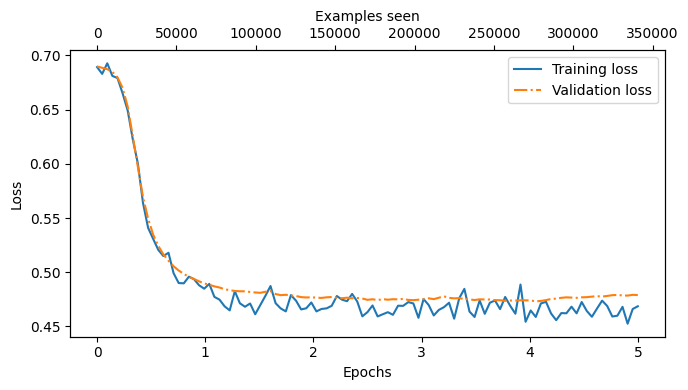

In [87]:
epochs_tensor: Tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor: Tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(
    epochs_seen=epochs_tensor,
    examples_seen=examples_seen_tensor,
    train_values=train_losses,
    val_values=val_losses,
)